## Super-Resolution Residual Neural Network

### It is the aim of this notebook to construct and train a convolutional neural network with a residual structure to create a very simple super-resolution tool for 32x32 images.

In [1]:
# Import the modules
import os
import imghdr
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Add, UpSampling2D
from tensorflow.keras.models import Model

C:\Users\huido\AppData\Local\Temp\ipykernel_18696\735506609.py:3: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


## Find and clean the data

In [2]:
# Read the 64x64 resolution images
images64_directory = 'resnet_images_dataset/High_Resolution/'

# Images possible extensions
image_exts = ['jpeg', 'png', 'bmp']

# Read and check the extension from the list of images
list_images = os.listdir(images64_directory)
for image in list_images:
    img_path = os.path.join(images64_directory, image)
    img_ext = imghdr.what(img_path)
    if img_ext not in image_exts: os.remove(img_path)
    else:
        try: img = Image.open(img_path)
        except: os.remove(img_path)

list_images = os.listdir(images64_directory)
N = len(list_images)
print('Number of images:', N)

Number of images: 195


In [3]:
# Check the correct format, downsample the images and save the result
images32_directory = 'resnet_images_dataset/Low_Resolution/'
for image in list_images:
    img_path = os.path.join(images64_directory, image)
    img = Image.open(img_path)
    
    # If the image is in p or RGBA mode, convert it to RGB
    if img.mode == 'p' or 'RGBA':
        img = img.convert('RGB')

    # Check the shape
    img_shape = np.asarray(img).shape
    if img_shape == (64, 64, 3):
        img.save(img_path)

        # Downsample by hand
        downsampled_img = img.resize((32, 32), Image.BILINEAR)
        downsampled_img.save(images32_directory+image)
    else:
        os.remove(img_path)

list_images = os.listdir(images64_directory)
N = len(list_images)
print('Number of images:', N)

Number of images: 195


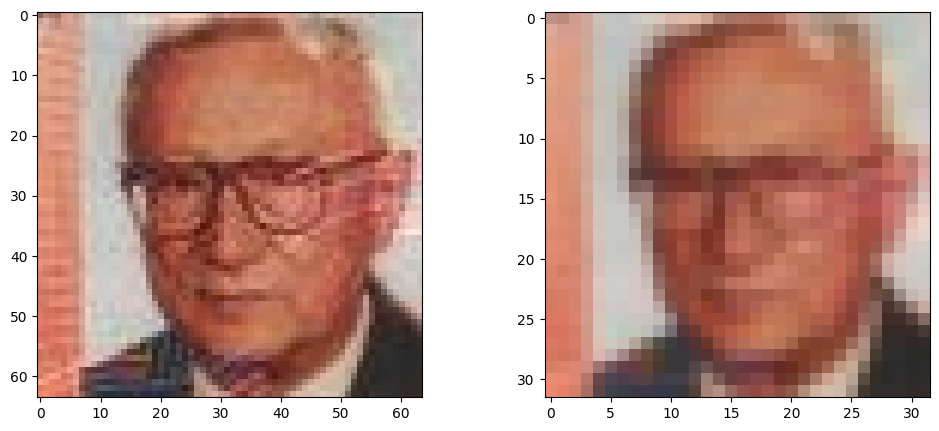

In [4]:
# Display an example
fig, axs = plt.subplots(ncols = 2, figsize = (12, 5))

axs[0].imshow(img)
axs[1].imshow(downsampled_img)

plt.show()

## Scale the data and split between training, validation and testing sets

In [5]:
# Read the clean data and rescale
scaled_data = []
list64_images = os.listdir(images64_directory)
list32_images = os.listdir(images32_directory)
for i in range(N):
    img = Image.open(images64_directory+list64_images[i])
    scaled_data.append(np.asarray(img)/255)
    img = Image.open(images32_directory+list32_images[i])
    scaled_data.append(np.asarray(img)/255)

In [6]:
# Split between inputs and targets
X = scaled_data[1::2]
y = scaled_data[::2]

# Split between train, val and test
train_size = int(N*0.7)
val_size = int(N*0.2) + 1
test_size = int(N*0.1) + 1

X_train, y_train = np.array(X[:train_size]), np.array(y[:train_size])
X_val, y_val = np.array(X[train_size:train_size+val_size]), np.array(y[train_size:train_size+val_size])
X_test, y_test = np.array(X[train_size+val_size:]), np.array(y[train_size+val_size:])

print('Size of the datasets:')
print('Train set:', X_train.shape, y_train.shape)
print('Validation set:', X_val.shape, y_val.shape)
print('Test set:', X_test.shape, y_test.shape)

Size of the datasets:
Train set: (136, 32, 32, 3) (136, 64, 64, 3)
Validation set: (40, 32, 32, 3) (40, 64, 64, 3)
Test set: (19, 32, 32, 3) (19, 64, 64, 3)


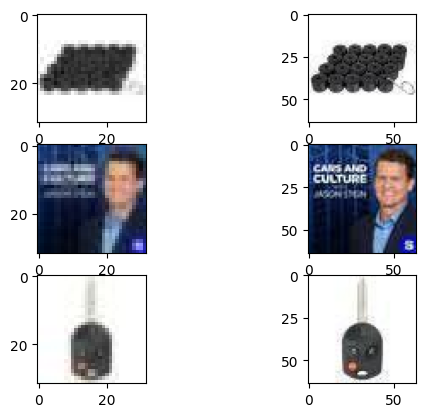

In [7]:
# Check the correct correspondence in each dataframe
fig, axs = plt.subplots(nrows = 3, ncols = 2)

# Training set
axs[0, 0].imshow(X_train[6])
axs[0, 1].imshow(y_train[6])
# Validation set
axs[1, 0].imshow(X_val[6])
axs[1, 1].imshow(y_val[6])
# Testing set
axs[2, 0].imshow(X_test[6])
axs[2, 1].imshow(y_test[6])

plt.show()

## Create the [model](https://en.wikipedia.org/wiki/Residual_neural_network)

In [8]:
def res_block(input_tensor, filters):
    x = Conv2D(filters, (3, 3), padding='same', activation='relu')(input_tensor)
    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = Add()([x, input_tensor])
    return x

def build_resnet_super_resolution(input_shape):
    inputs = Input(shape=input_shape)

    # Initial Convolutional Layer
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(inputs)

    # Residual Blocks
    for _ in range(5):  # Adjust the number of residual blocks as needed
        x = res_block(x, 64)

    # Upsampling Layer (2x upscaling)
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)

    # Output Layer to match the target resolution (64x64)
    outputs = Conv2D(3, (3, 3), padding='same', activation='sigmoid')(x)

    # Model
    model = Model(inputs, outputs)
    return model

In [9]:
# Define the input shape (32x32x3 for RGB images)
input_shape = (32, 32, 3)
model = build_resnet_super_resolution(input_shape)

# Compile the model
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])

# Summary of the model
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     36,928 │ conv2d_1[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32,    │          0 │ conv2d_2[0][0],   │
│                     │ 64)               │            │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │     36,928 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     36,928 │ conv2d_3[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 32, 32,    │          0 │ conv2d_4[0][0],   │
│                     │ 64)               │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     36,928 │ add_1[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │     36,928 │ conv2d_5[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 32, 32,    │          0 │ conv2d_6[0][0],   │
│                     │ 64)               │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │     36,928 │ add_2[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │     36,928 │ conv2d_7[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 32, 32,    │          0 │ conv2d_8[0][0],   │
│                     │ 64)               │            │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 32,    │     36,928 │ add_3[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 32, 32,    │     36,928 │ conv2d_9[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 32, 32,    │          0 │ conv2d_10[0][0],

 Total params: 409,731 (1.56 MB)

 Trainable params: 409,731 (1.56 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Train the model
history = model.fit(X_train, y_train, 
                    validation_data = (X_val, y_val), 
                    epochs = 50,
                    batch_size = 32)

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.5054 - loss: 0.1264 - val_accuracy: 0.2335 - val_loss: 0.0694
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.3294 - loss: 0.0794 - val_accuracy: 0.6377 - val_loss: 0.0448
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.5840 - loss: 0.0485 - val_accuracy: 0.3694 - val_loss: 0.0398
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.4989 - loss: 0.0413 - val_accuracy: 0.6248 - val_loss: 0.0281
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.5665 - loss: 0.0318 - val_accuracy: 0.3917 - val_loss: 0.0181
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.3942 - loss: 0.0253 - val_accuracy: 0.5062 - val_loss: 0.0152
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.5447 - loss: 0.0233 - val_accuracy: 0.5181 - val_loss: 0.0124
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5367 - loss: 0.0196 - val_accuracy: 0.5874 - val_loss: 0.0110
Epoch 9/50
5/

In [11]:
# Evaluate on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.7252 - loss: 0.0043
Test Loss: 0.00428240979090333, Test Accuracy: 0.7252389788627625


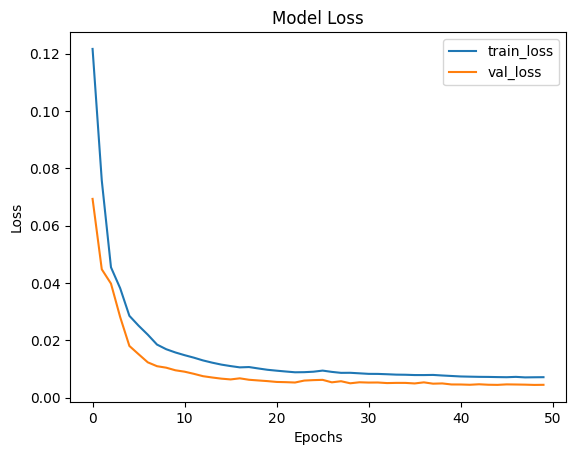

In [12]:
# Plot training and validation loss
plt.plot(history.history['loss'], label = 'train_loss')
plt.plot(history.history['val_loss'], label = 'val_loss')

plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()

plt.show()

In [13]:
# Make predictions on test data
predictions = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


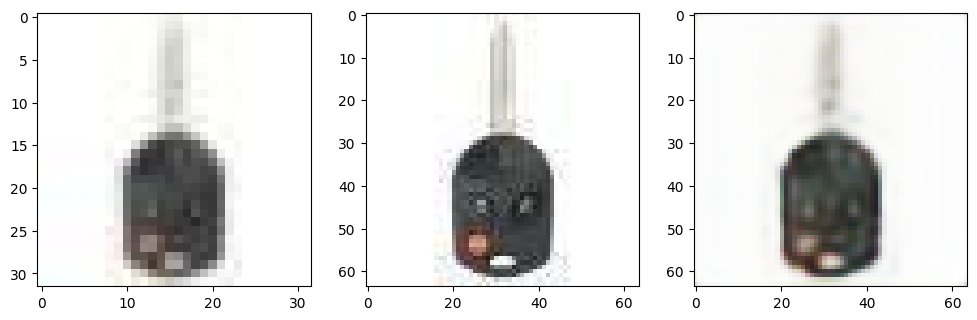

In [14]:
# Visualize the original low-res, predicted high-res, and ground truth high-res images
fig, axs = plt.subplots(ncols = 3, figsize = (12, 5))

# Show 5 examples
axs[0].imshow(X_test[6])
axs[1].imshow(y_test[6])
axs[2].imshow(predictions[6])

plt.show()